In [ ]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
# benchmarking against GRNbenchmark
from geneRNI import geneRNI as ni
from geneRNI import utils
import os
import pandas as pd
import numpy as np

import importlib
importlib.reload(ni)
importlib.reload(utils)

param = dict(
    estimator_t = 'RF',
    n_estimators = 50,
    n_jobs = 10,
) 

dir_main = 'C:/Users/nourisa/Downloads/testProjs/omics'

dir_benchmark_out = os.path.join(dir_main,'results/benchmark')
pr1 = ['GeneNetWeaver']
# pr2 = ['HighNoise', 'LowNoise', 'MediumNoise']
# pr3 = ['Network1', 'Network2_', 'Network3_', 'Network4', 'Network5']
# pr2 = ['HighNoise_']
# pr3 = ['Network1_']
data_stack = [] # list of (Xs,ys) for differnt experiments
for i_1 in pr1:
    for i_2 in pr2:
        for i_3 in pr3:
            exp_data, per_data, gene_names = f_data_GRN(i_1, i_2, i_3)

#             Xs, ys = utils.process_static_data(SS_data = exp_data, gene_names=gene_names, KO = per_data)
            
#             ests, scores_train, links, oob_scores = ni.network_inference(Xs, ys, param)
            
#             out_file = base + '_grn.csv'
#             out_file = os.path.join(dir_benchmark_out, out_file)
#             utils.output_links(links, gene_names=gene_names, file_name=out_file)
#             data_stack.append((exp_data, per_data))

static data: ngenes: 100, nsamples: 300, n regulators: 100

network inference: train score, mean: 0.9938898090597094 std: 0.0047750313308184515
network inference: oob score (only RF), mean: 0.9552373028672413 std: 0.03317494198438678


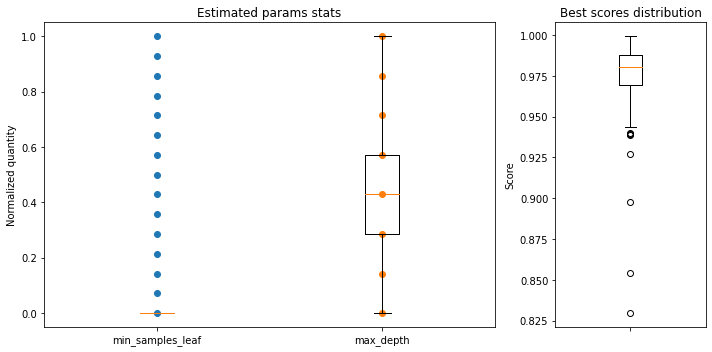

In [9]:
# post processing: calculate links, golden precision scores, and plot param distribution 
import os
import ast
import importlib
import pandas as pd
import numpy as np
from geneRNI import search_param
from geneRNI import tools
from geneRNI import geneRNI as ni
import itertools
import random
importlib.reload(search_param)
importlib.reload(ni)
importlib.reload(tools)

dir_main = 'C:/Users/nourisa/Downloads/testProjs/omics'
output_dir=os.path.join(dir_main,'results')
# choose the study 
# size, network, study= 10, 1, 'dreams'
method, noise_level, network, study= 'GeneNetWeaver', 'LowNoise', 'Network1', 'GRNbenchmark'

# recreate the experiment
estimator_t = 'RF' #'HGB'
study = 'GRNbenchmark' #'GRNbenchmark'

if study == 'dreams': # dream as target study
    size, network = 10, 1 # [10,100] [1-5]
    out_data = tools.Benchmark.process_data_dreams(size=size, network=network, estimator_t=estimator_t)
    results_dir = f'results/param_search_dream_{size}_{network}.txt'
elif study == 'GRNbenchmark':
    method, noise_level, network = 'GeneNetWeaver', 'LowNoise', 'Network1'
    out_data = tools.Benchmark.process_data_GRNbenchmark(method, noise_level, network, estimator_t=estimator_t)
    results_dir = f'results/param_search_GRNbenchmark_{method}_{noise_level}_{network}.txt'
else:
    raise ValueError('Define')
out_defaults = tools.Settings.default(estimator_t=estimator_t)

# retreieve param search results
with open(results_dir,'r') as f:
    out = ast.literal_eval(f.read())
best_scores, best_params = out['best_scores'], out['best_params']

# param_unique = tools.param_unique_average(best_params)
param_unique = best_params
# nework inference
_, train_scores, links, oob_scores, test_scores = ni.network_inference(Xs=out_data.Xs_train, ys=out_data.ys_train, 
                                                                       param=out_defaults.param, Xs_test=out_data.Xs_test, 
                                                                       ys_test=out_data.ys_test, param_unique=param_unique)

# plot
with open(os.path.join(output_dir,'permts.txt'),'r') as f:
    permts = ast.literal_eval(f.read())
with open(os.path.join(output_dir, 'sampled_permts.txt'), 'r') as f:
    sampled_permts = ast.literal_eval(f.read())
search_param.plot(best_params,best_scores, priors = permts, samples = sampled_permts)

In [ ]:
# plot precision vs racals
precision, recall, average_precision = utils.calculate_PR(gene_names=gene_names, scores=scores, tests=tests, details = True)

utils.PR_curve_average(recall=recall, precision=precision, average_precision=average_precision)
utils.PR_curve_gene(gene_names=gene_names[0:2], precision=precision, recall=recall, average_precision=average_precision)

In [ ]:
# write test data for R
TS_data, time_points, SS_data, gene_names = f_data_dream(size, network)
np.savetxt('data/test_data.csv',SS_data.transpose(), delimiter=',')

In [ ]:
# calculate precision score for r results
import os
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import sys
dir_main = 'C:/Users/nourisa/Downloads/testProjs/omics'

sys.path.insert(0, dir_main)
from geneRNI import tools

size = 10 # [10,100]
network = 1 # [1-5]

def f_golden_dream(size, network): 
    """ retreives golden links for dreams for given size and network """
    dir_ = os.path.join(dir_main,f'dynGENIE3/dynGENIE3_data/dream4/gold_standards/{size}/DREAM4_GoldStandard_InSilico_Size{size}_{network}.tsv')
    return pd.read_csv(dir_, names=['Regulator','Target','Weight'] ,sep='\t') 
def f_dir_links(size, network):
    """ returns the dir to the stored links """
    return os.path.join(dir_main,f'results/test_links.csv')
def f_data_dream(size, network): 
    """ retreives train data for dreams for given size and network"""
    (TS_data, time_points, SS_data) = pd.read_pickle(os.path.join(dir_main,f'dynGENIE3/dynGENIE3_data/dream4/data/size{size}_{network}_data.pkl'))
    gene_names = [f'G{i}' for i in range(1,size+1)]
    return TS_data, time_points, SS_data, gene_names
TS_data, time_points, SS_data, gene_names = f_data_dream(size, network)
links = pd.read_csv(f_dir_links(size, network) )
goldens = f_golden_dream(size, network)
# sort links based on each gene
links_sorted = tools.sort_links(links,gene_names)
goldens_sorted = tools.sort_links(goldens,gene_names)
# calculate PR
scores = np.array(list(goldens_sorted.values()))
tests = np.array(list(links_sorted.values()))
_, _, _, average_precision_overall = tools.calculate_PR(gene_names=gene_names, scores=scores, tests=tests, details = False)
print('average precision : ',average_precision_overall)

In [ ]:
## dynGENIE3
import importlib
from dynGENIE3 import dynGENIE3 
importlib.reload(dynGENIE3)
import _pickle

(VIM, alphas, prediction_score, stability_score, treeEstimators) = dynGENIE3.dynGENIE3(TS_data = None, SS_data = SS_data,time_points=time_points)